In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [ ]:
sub = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [ ]:
test_data.isna().sum()

In [ ]:
train_data.head()

In [ ]:
# Identifying missing value
train_data.isna().sum()/len(train_data)

In [ ]:
# As cabin has almost 77% missing data , we better remove it 
train_data = train_data.drop("Cabin",axis=1)
test_data = test_data.drop("Cabin",axis=1)

In [ ]:
# Remove passenger id 
train_data = train_data.drop("PassengerId",axis=1)

Now we have 2 columns with missing value in which one is embarked and one is Age

In [ ]:
train_data.Embarked.isna().sum() # Has only 2 missing so dropping these rows will cause no harm

In [ ]:
train_data = train_data[train_data.Embarked.notna()]

In [ ]:
# Getting description of train data
train_data.describe()

In [ ]:
#set(train_data.Name.str.split(",").apply(lambda x:x[1].split()[0]))
#train_data["Title"] = train_data.Name.str.split(",").apply(lambda x:x[0].strip())

In [ ]:
median = train_data.groupby(["Sex","Pclass"]).median()["Age"].reset_index()
median_test = test_data.groupby(["Sex","Pclass"]).median()["Age"].reset_index()

In [ ]:
# The median of the group will be replaced with the median of group of Sex and Pclass
missing_train_data = train_data[train_data.Age.isna()]
missing_train_data_cp = missing_train_data.drop(columns = ["Age"])[["Sex","Pclass"]]
non_missing_train_data = train_data[~train_data.Age.isna()]
missing_train_data["Age"] = missing_train_data_cp.merge(median,on=["Sex","Pclass"]).Age
train_data = pd.concat([missing_train_data,non_missing_train_data])
print(train_data.head(3))


# The median of the group will be replaced with the median of group of Sex and Pclass
missing_test_data = test_data[test_data.Age.isna()]
missing_test_data_cp = missing_test_data.drop(columns = ["Age"])[["Sex","Pclass"]]
non_missing_test_data = test_data[~test_data.Age.isna()]
missing_test_data["Age"] = missing_test_data_cp.merge(median,on=["Sex","Pclass"]).Age
test_data = pd.concat([missing_test_data,non_missing_test_data])
print("Test Data-> \n",test_data.head())

In [ ]:
# Impute rest of the missing data by median
train_data.Age.fillna(median.Age.median(),inplace=True)
print("Tain data impute",train_data.isna().sum())

# Impute rest of the missing data by median
test_data.Age.fillna(median_test.Age.median(),inplace=True)
print("Test Data Impute",test_data.isna().sum())

In [ ]:
# Replacing Fare with the median value of fares of that class
pclass_ = int(test_data[test_data.Fare.isna()].Pclass.values)
test_data.Fare.fillna(test_data[test_data.Pclass == pclass_].Fare.median(),inplace=True)

In [ ]:
test_data.isna().sum()

In [ ]:
# Plotting correlation matrix
train_data.corr()

In [ ]:
# Dropping Name and ticket column as they have high number of unique values
train_data = train_data.drop(columns=["Ticket","Name"])
test_data = test_data.drop(columns=["Ticket","Name"])

In [ ]:
for col in train_data:
    print("% of unique values in "+col+" -> ",len(set(train_data[col]))/len(train_data))
    print("Class frequency in each column-> \n",train_data[col].value_counts().head(5))

In [ ]:
# converting Categourical data to one hot encoding
train_data["Sex"] = train_data["Sex"].map({"male":1,"female":0})
test_data["Sex"] = test_data["Sex"].map({"male":1,"female":0})

In [ ]:
train_data =pd.concat([train_data,pd.get_dummies(train_data.Embarked,prefix="Emb",drop_first=True)],axis=1)
test_data =pd.concat([test_data,pd.get_dummies(test_data.Embarked,prefix="Emb",drop_first=True)],axis=1)

In [ ]:
train_data = train_data.drop(columns = ["Embarked"])
test_data = test_data.drop(columns = ["Embarked"])

In [ ]:
# Data for Random forest and decision tree models 
X_train_tree = train_data.drop(columns=['Survived'])
y_train_tree = train_data.Survived

X_test_tree = test_data.drop("PassengerId",axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

In [244]:
rf = RandomForestClassifier(n_estimators=800,min_samples_split=10,min_samples_leaf=1)

In [245]:
rf.fit(X_train_tree,y_train_tree)
y_tran_pred_tree = rf.predict(X_train_tree)

In [246]:
rf.score(X_train_tree,y_train_tree)

0.8785151856017998

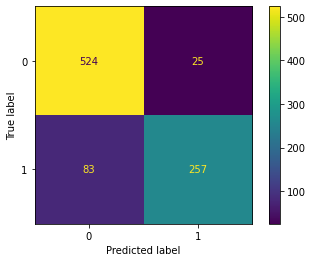

In [247]:
ConfusionMatrixDisplay(confusion_matrix(y_train_tree,y_tran_pred_tree)).plot()

In [248]:
# Predicting the score 
y_pred = rf.predict(X_test_tree)

In [249]:
# Submission of results
result = test_data[["PassengerId"]]
result["Survived"] = y_pred

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [250]:
result.to_csv("/kaggle/working/titanic_submission.csv",index=False)

In [ ]:
result.to_csv("submission.csv",index=False)